 # Finetune a GET Model on PBMC 10k ATAC


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using motif information and quantitative ATAC signal. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Perform various analysis using `gcell` package



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.cell.celltype import GETHydraCellType
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


Failed to load image Python extension: '/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?


 ## Finetune



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial_pbmc.yaml`

In [14]:
if not Path('./checkpoint-best.pth').exists():
    s3_checkpoint_url = "s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth"
    ! aws s3 cp $s3_checkpoint_url ./checkpoint-best.pth --no-sign-request

In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [5]:
celltype_for_modeling = [    
    'memory_b',
    'cd14_mono',
    'gdt',
    'cd8_tem_1',
    'naive_b',
    'mait',
    'intermediate_b',
    'cd4_naive',
    'cd8_tem_2',
    'cd8_naive',
    'cd4_tem',
    'cd4_tcm',
    'cd16_mono',
    'nk',
    'cdc',
    'treg']
cfg = load_config('finetune_tutorial_pbmc') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac'
cfg.dataset.quantitative_atac = False # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./pbmc10k_multiome.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = 'cd4_tcm' # set the celltypes you want to leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac
training for 50 epochs


Now we can start the finetuning

In [4]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)

Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


2025-01-06 17:03:49,945 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin


  0%|          | 0/15 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


  7%|▋         | 1/15 [00:00<00:02,  4.69it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 20%|██        | 3/15 [00:00<00:02,  4.77it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 33%|███▎      | 5/15 [00:01<00:02,  4.86it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 40%|████      | 6/15 [00:01<00:01,  5.20it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 47%|████▋     | 7/15 [00:01<00:01,  4.82it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 60%|██████    | 9/15 [00:01<00:01,  4.77it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 73%|███████▎  | 11/15 [00:02<00:00,  4.62it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 80%|████████  | 12/15 [00:02<00:00,  4.33it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 87%|████████▋ | 13/15 [00:02<00:00,  4.42it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Interpretation

After finetuning, we can use the checkpoint to predict expression of all accessible genes and generate jacobian matrix of (peak x motif) for every predicted genes. 
To start, we need to collect the checkpoint we produced and switch to `predict` stage. Here, let's focus on CD4 Naive cell and we need to set `cfg.leave_out_celltypes` to `cd4_naive` for the model to predict gene expression in this cell type.

In [6]:
use_checkpoint = '~/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints/best-v2.ckpt' #trainer.checkpoint_callback.best_model_path
cfg.stage = 'predict'
cfg.finetune.resume_ckpt = use_checkpoint
# in predict stage, leave out the celltype you want to interpret
cfg.run.use_wandb=False # disable wandb logging when predicting
cfg.task.layer_names = [] # set to empty list to disable intermediate layer interpretation
cfg.task.gene_list = None # set to None to predict all genes; otherwise you can specify a list of genes as 'MYC,SOX10,SOX2,RET', only genes with promoter open will be used
# loop through all celltypes and run the predict stage
cfg.run.run_name='interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac'

for celltype in ['cd4_naive']:
    cfg.dataset.leave_out_celltypes = celltype 
    trainer = run(cfg)





Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/lightning/pytorch/loops/prediction_loop.py:255: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd4_naive.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd4_naive.zarr


As you can see, the results is now saved to `finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split/cd4_naive.zarr`. Now we can use the `GETHydraCellType` class from `gcell` to load it.

In [2]:
# get the celltype object based on the configuration
celltype = 'cd4_naive'
cfg = load_config('finetune_tutorial_pbmc')
cfg.run.run_name='interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac'
cfg.dataset.leave_out_celltypes = celltype 
hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here



In [3]:
hydra_celltype

GETHydraCelltype: cd4_naive
        Zarr path: /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd4_naive.zarr
        Number of regions per sample: 200
        Number of features: 283
        Number of genes: 15306
        Number of peaks: 3061200
        

We can plot the predicted and observed expression to see whether there is any issue.

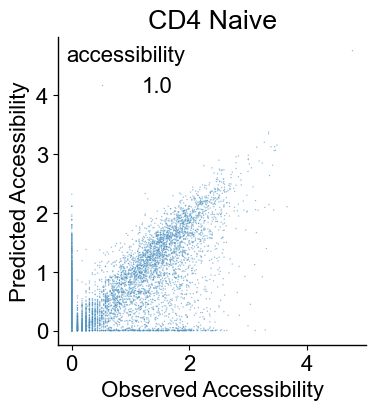

In [4]:
# set dpi to 100 
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data = hydra_celltype.gene_annot, x='obs', y = 'pred', hue='accessibility', s=1, alpha=0.5, ax=ax)
ax.set_title('CD4 Naive')
ax.set_xlabel('Observed Accessibility')
ax.set_ylabel('Predicted Accessibility')
ax.set_aspect('equal')
plt.show()


The summarized gene-by-motif importance matrix can be accessed through `hydra_celltype.gene_by_motif` property. The following function will retrieve and save it to disk.

In [5]:
# takes around 30 min on 16 cores, TODO should be able to run in parallel
hydra_celltype.get_gene_by_motif()

After gene-by-motif matrix is saved, we can perform causal discovery between different motifs. This is done via `.get_causal()` function. The results will also be saved to disk. Here we will perform 3 independent run with column (motif) permutation (since the LIN)

In [6]:
# takes around 30 min on 16 cores
hydra_celltype.gene_by_motif.get_causal()



Let's have a look at CD4 Naive RNA-seq to find some interesting TF to study: it seems that LEF1 and BACH2 are good marker genes for 'CD4 Naive' (also CD8 Naive)

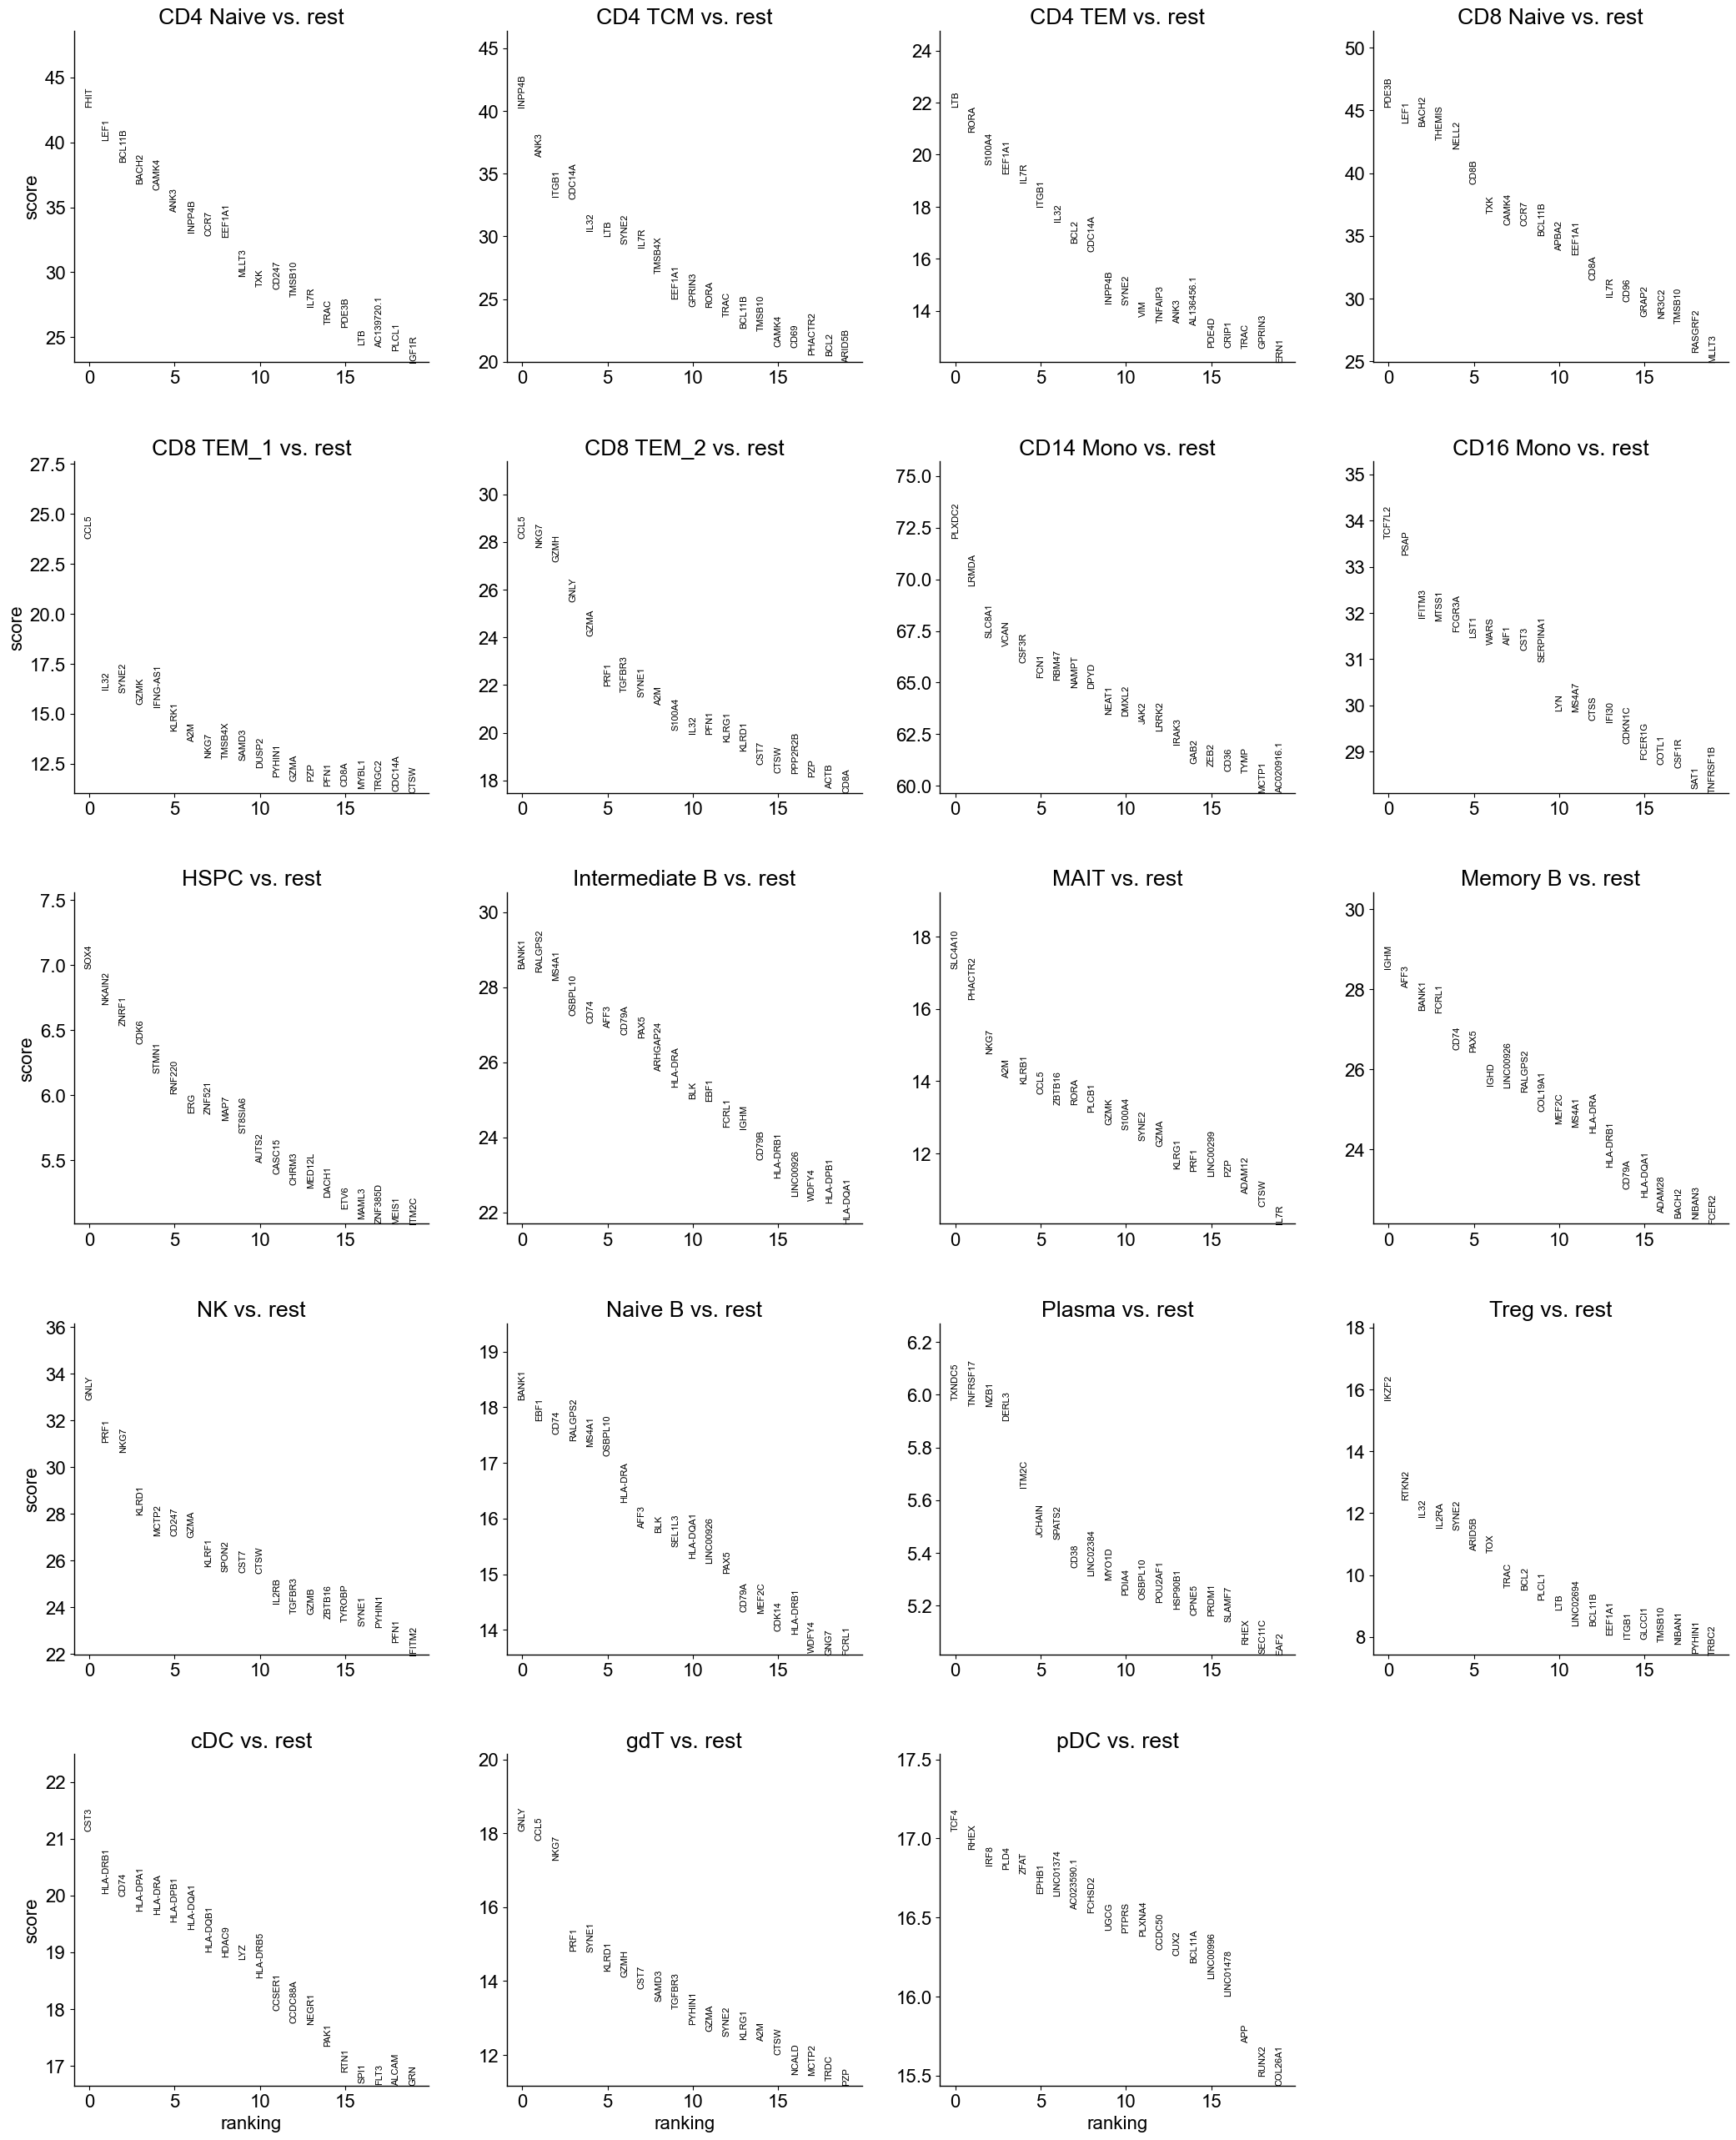

In [7]:
# load the scanpy object
import scanpy as sc
rna_filtered = sc.read('rna.h5ad')
# get marker genes for 'CD4 Naive'
sc.tl.rank_genes_groups(rna_filtered, 'cell_type', method='wilcoxon', rankby_abs=False)
sc.pl.rank_genes_groups(rna_filtered, n_genes=20, sharey=False)


Check which motif cluster LEF1 and BACH2 belongs to...

In [8]:
hydra_celltype.motif.annotations.query('Motif.str.startswith("BACH")')

,Cluster_ID,Motif,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
719,53,BACH1_HUMAN.H11MO.0.A,HOCOMOCO_v11,TGCTGAGTCATGC,+,13,4,2,AP1/2,bZIP,BACH1_HUMAN.H11MO.0.A,19,4,15,12
721,53,BACH2_HUMAN.H11MO.0.A,HOCOMOCO_v11,TGCTGAGTCAT,+,11,4,4,AP1/2,bZIP,BACH1_HUMAN.H11MO.0.A,19,4,15,12
722,53,BACH2_MOUSE.H11MO.0.A,HOCOMOCO_v11,TGCTGAGTCAT,+,11,4,4,AP1/2,bZIP,BACH1_HUMAN.H11MO.0.A,19,4,15,12
723,53,BACH1_MOUSE.H11MO.0.C,HOCOMOCO_v11,TGCTGAGTCATGGT,+,14,4,1,AP1/2,bZIP,BACH1_HUMAN.H11MO.0.A,19,4,15,12
727,53,BACH2_MA1101.1,Jaspar2018,ATTGCTGAGTCATC,-,14,2,3,AP1/2,bZIP,BACH1_HUMAN.H11MO.0.A,19,4,15,12


In [9]:
hydra_celltype.motif.annotations.query('Motif.str.startswith("LEF")')


,Cluster_ID,Motif,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
442,29,LEF1_MA0768.1,Jaspar2018,AAAGATCAAAGGGTT,+,15,2,0,TCF/LEF,HMG,LEF1_HMG_1,17,3,13,12
446,29,LEF1_HMG_1,Taipale_Cell_2013,AAAGATCAAAGGGTT,+,15,2,0,TCF/LEF,HMG,LEF1_HMG_1,17,3,13,12
1586,120,LEF1_HUMAN.H11MO.0.A,HOCOMOCO_v11,TCCTTTGATTTGCT,+,14,3,1,LEF1,HMG,LEF1_HUMAN.H11MO.0.A,18,3,16,4
1587,120,LEF1_MOUSE.H11MO.0.B,HOCOMOCO_v11,TCCTTTGATTTGCT,+,14,3,1,LEF1,HMG,LEF1_HUMAN.H11MO.0.A,18,3,16,4


Let's use LEF1 and AP1/2 for subnetwork analysis

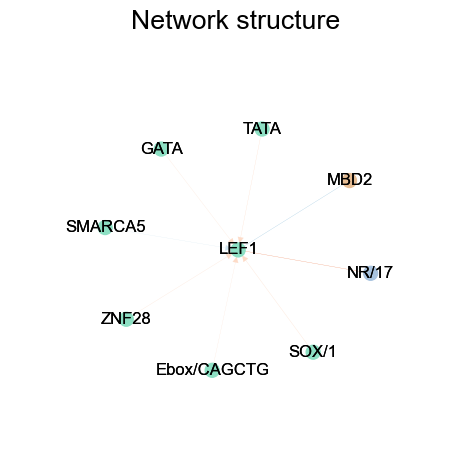

In [38]:
g = hydra_celltype.gene_by_motif.get_causal()
g_ = preprocess_net(g, 0.1)
plot_comm(get_subnet(g_.copy(), 'LEF1'), figsize=(5, 5))

While not shown in string database, LEF1 interacts with GATA3 https://pmc.ncbi.nlm.nih.gov/articles/PMC2669141/ 
and Ebox/CAGCTG contains TCF3/TCF12/TCF21. Where TCF12 is highly expressed. NR/17 is the strongest interaction, corresponding to RARG, PPARG or ESR1, where ESR1 is the highest expressed one.

In [42]:
hydra_celltype.gene_annot.query('gene_name.isin(["TCF12", "TCF21", "TCF3", "GATA3", "RARG", "ESR1", "PPARG"])').sort_values('pred', ascending=False)

,gene_name,Chromosome,Start,End,Strand,pred,obs,accessibility
12957,TCF12,chr15,57218880,57219800,0,2.290304,2.504335,1.0
4687,GATA3,chr10,8054415,8055170,0,1.534251,1.804037,1.0
3956,ESR1,chr6,151807792,151808640,0,1.158922,1.812437,1.0
3954,ESR1,chr6,151690000,151690720,0,0.908687,1.812437,1.0
10020,PPARG,chr3,12350997,12351720,0,0.150964,0.000000,1.0
12963,TCF3,chr19,1652470,1653350,1,0.097812,0.000000,1.0
10667,RARG,chr12,53231896,53232732,1,0.038415,0.000000,1.0
10666,RARG,chr12,53220120,53220624,1,0.007171,0.000000,1.0
3955,ESR1,chr6,151807024,151807616,0,0.002079,0.000000,1.0
10019,PPARG,chr3,12287657,12288418,0,0.000554,0.000000,1.0


In terms of AP1/2 (BACH2):

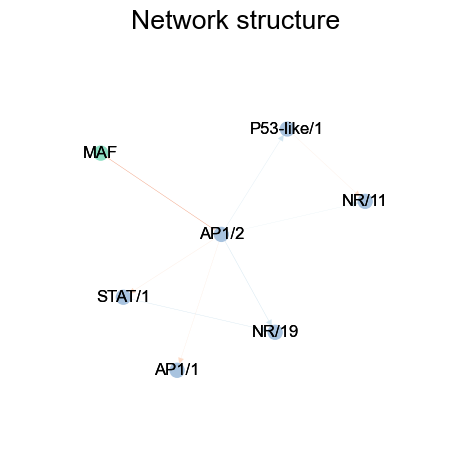

In [260]:
g = hydra_celltype.gene_by_motif.get_causal()
g_ = preprocess_net(g, 0.1)
plot_comm(get_subnet(g_.copy(), 'AP1/2'), figsize=(5, 5))

Note that BACH2-MAF is a known interaction

In [23]:
from gcell.protein.stringdb import get_string_network
get_string_network(["BACH2"], species='human', network_type='physical', required_score=400).query('preferredName_A=="BACH2"')

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
2,9606.ENSP00000257749,9606.ENSP00000380321,BACH2,TULP3,9606,0.457,0,0,0,0,0.457,0.0,0.000
3,9606.ENSP00000257749,9606.ENSP00000382805,BACH2,BACH1,9606,0.465,0,0,0,0,0.465,0.0,0.000
4,9606.ENSP00000257749,9606.ENSP00000360266,BACH2,JUN,9606,0.468,0,0,0,0,0.187,0.0,0.373
5,9606.ENSP00000257749,9606.ENSP00000384018,BACH2,NCOR2,9606,0.810,0,0,0,0,0.359,0.0,0.717
6,9606.ENSP00000257749,9606.ENSP00000344903,BACH2,MAFK,9606,0.849,0,0,0,0,0.575,0.0,0.659
7,9606.ENSP00000257749,9606.ENSP00000268712,BACH2,NCOR1,9606,0.854,0,0,0,0,0.164,0.0,0.832
8,9606.ENSP00000257749,9606.ENSP00000442060,BACH2,MAFF,9606,0.867,0,0,0,0,0.407,0.0,0.786
9,9606.ENSP00000257749,9606.ENSP00000350369,BACH2,MAFG,9606,0.920,0,0,0,0,0.627,0.0,0.795
10,9606.ENSP00000257749,9606.ENSP00000327048,BACH2,MAF,9606,0.961,0,0,0,0,0.047,0.0,0.961


We can check the predicted target gene average expression. Here we use the raw counts normalized by library size to compute the average expression, and performed that for AP1/2 and LEF1. 

In [43]:
import numpy as np
import snapatac2 as snap
import scanpy as sc
rna = snap.read(snap.datasets.pbmc10k_multiome(modality='RNA'), backed=None)

data = hydra_celltype.gene_by_motif.data.copy()

X = sc.pp.normalize_total(rna, inplace=False)['X']

lef1_regulated_genes = data[['LEF1']].abs().sum(axis=1).sort_values(ascending=True).tail(500).index.tolist()
lef1_non_regulated_genes = data[['LEF1']].abs().sum(axis=1).sort_values(ascending=True).head(500).index.tolist()

lef1_regulated_genes_exp = (X[:, rna.var.index.isin(lef1_regulated_genes)]).mean(axis=1)
lef1_regulated_genes_exp = np.array(lef1_regulated_genes_exp).flatten()
rna_filtered.obs['lef1_regulated_genes_exp'] = lef1_regulated_genes_exp

lef1_non_regulated_genes_exp = (X[:, rna.var.index.isin(lef1_non_regulated_genes)]).mean(axis=1)
lef1_non_regulated_genes_exp = np.array(lef1_non_regulated_genes_exp).flatten()
rna_filtered.obs['lef1_non_regulated_genes_exp'] = lef1_non_regulated_genes_exp

ap1_regulated_genes = data[['AP1/2']].abs().sum(axis=1).sort_values(ascending=True).tail(500).index.tolist()
ap1_non_regulated_genes = data[['AP1/2']].abs().sum(axis=1).sort_values(ascending=True).head(500).index.tolist()

ap1_regulated_genes_exp = (X[:, rna.var.index.isin(ap1_regulated_genes)]).mean(axis=1)
ap1_regulated_genes_exp = np.array(ap1_regulated_genes_exp).flatten()
rna_filtered.obs['ap1_regulated_genes_exp'] = ap1_regulated_genes_exp

ap1_non_regulated_genes_exp = (X[:, rna.var.index.isin(ap1_non_regulated_genes)]).mean(axis=1)
ap1_non_regulated_genes_exp = np.array(ap1_non_regulated_genes_exp).flatten()
rna_filtered.obs['ap1_non_regulated_genes_exp'] = ap1_non_regulated_genes_exp


Note that one of the top marker gene FHIT is predicted to be regulated by LEF1.

In [47]:
'FHIT' in lef1_regulated_genes

True

Let's plot the average expression of predicted targets or non-targets of LEF1 and AP1/2:

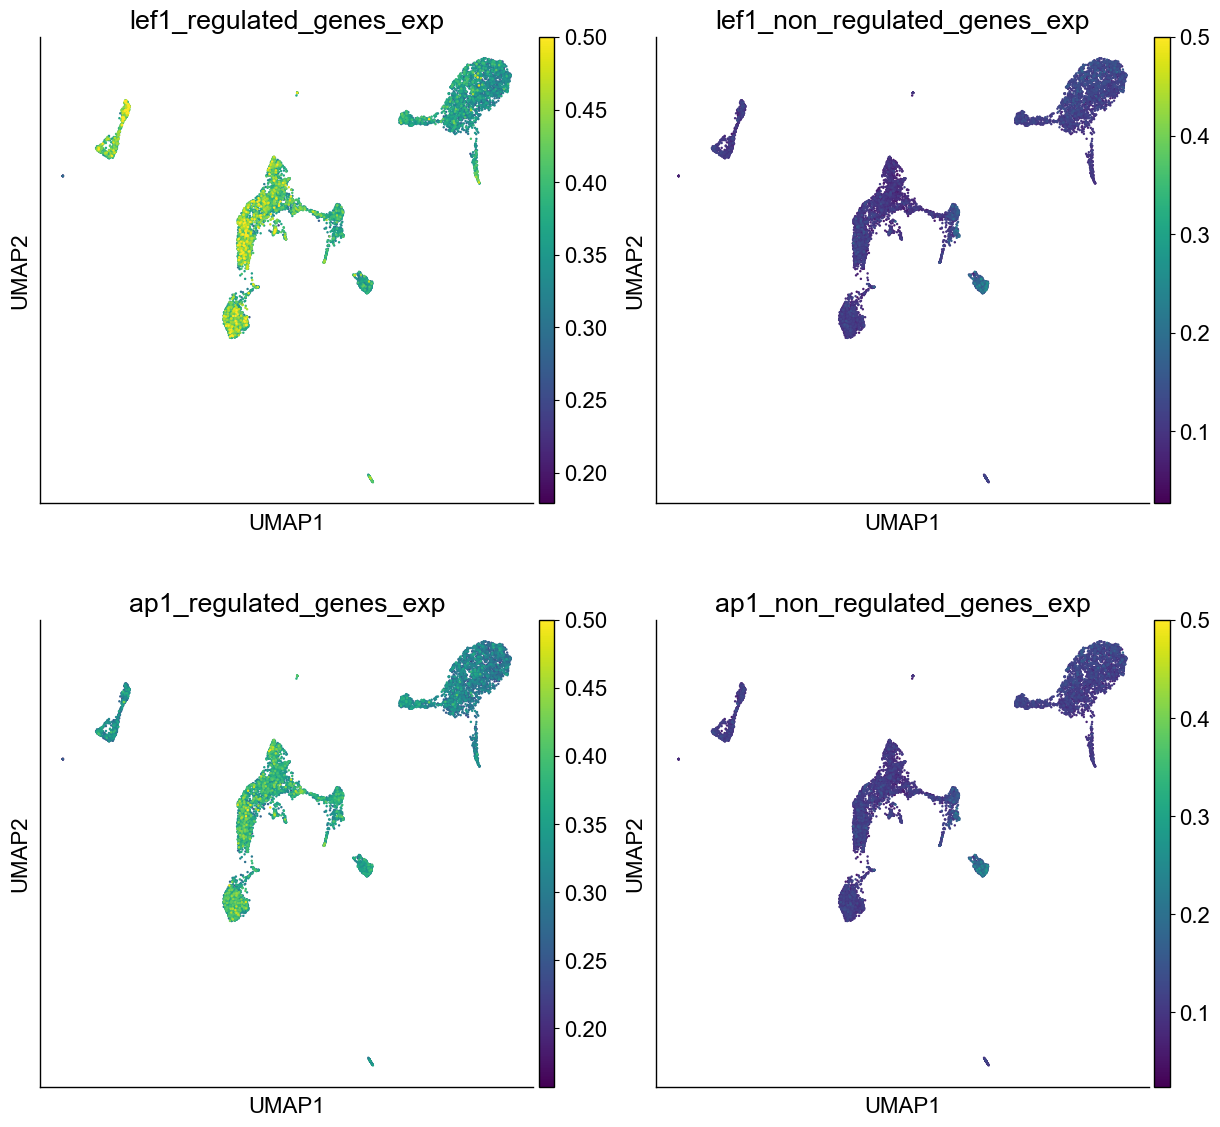

In [44]:
sc.pl.umap(rna_filtered, color=['lef1_regulated_genes_exp', 'lef1_non_regulated_genes_exp',
                                'ap1_regulated_genes_exp', 'ap1_non_regulated_genes_exp'], vmax=0.5, ncols=2)

And the expression of LEF1, BACH2, ESR1, and TCF12. 

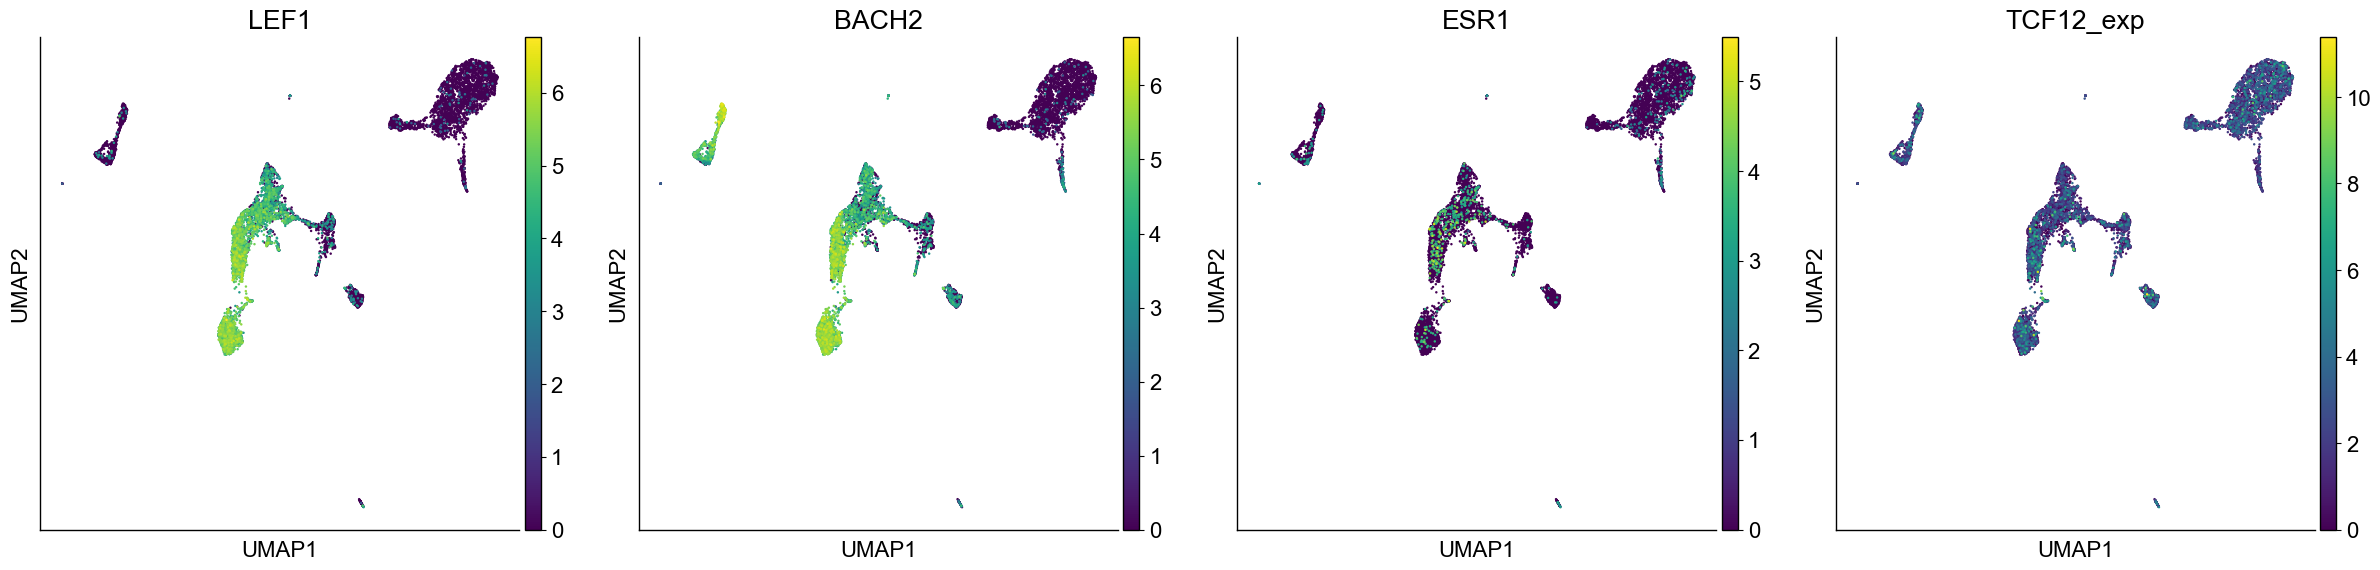

In [46]:
sc.pl.umap(rna_filtered, color=['LEF1', 'BACH2', 'ESR1', 'TCF12_exp'])

We can have a more detailed look into FHIT:

In [54]:
hydra_celltype.get_gene_jacobian_summary('FHIT').sort_values().tail(20)

NR/18            0.002649
TFAP2/2          0.002677
NR/17            0.002762
RBPJ             0.002775
PRDM5            0.002797
E2F/4            0.002845
RFX/1            0.002894
ZNF57            0.002901
NRF1             0.002987
HINFP1/1         0.003039
KLF/SP/2         0.003364
Ebox/CACGTG/2    0.003471
NFY              0.003543
Accessibility    0.003611
NFAT/2           0.003739
E2F/3            0.003768
ZBTB14           0.004202
ETS/1            0.004445
ZFX              0.004988
CTCF             0.006775
dtype: float32

Note that FHIT might also be regulated by NFAT/2 --> NFATC3. ZFX, CTCF and ETS/1 are usually very general promoter architecture so let's ignore them here.

In [89]:
genes = hydra_celltype.motif.cluster_gene_list['NFAT/2']
hydra_celltype.gene_annot.query('gene_name.isin(@genes)')

,gene_name,Chromosome,Start,End,Strand,pred,obs,accessibility
8643,NFAT5,chr16,69565520,69566360,0,0.000588,0.000000,1.0
8644,NFATC1,chr18,79395784,79396408,0,0.000068,0.000000,1.0
8645,NFATC1,chr18,79399928,79400672,0,0.616281,1.880092,1.0
8648,NFATC3,chr16,68084896,68085720,0,2.222104,2.403093,1.0


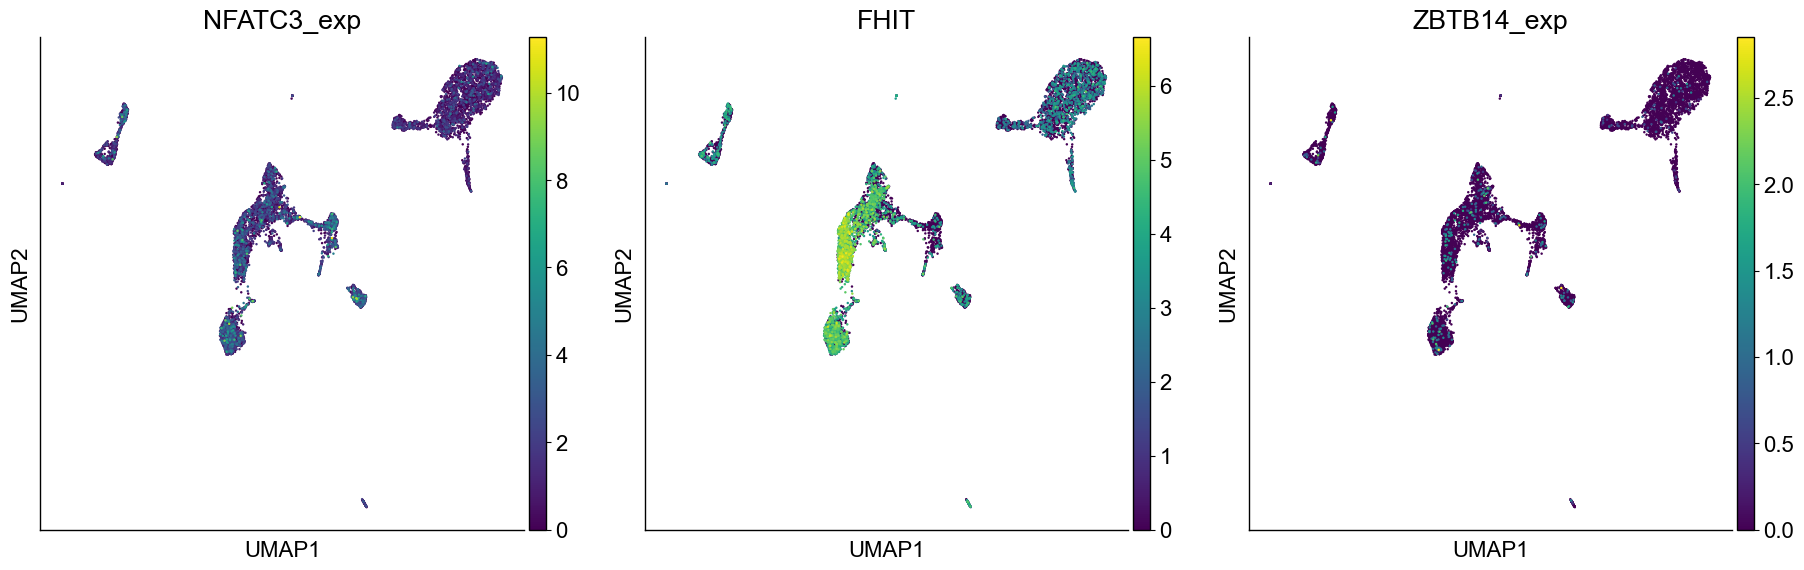

In [98]:
rna_filtered.obs['NFATC3_exp'] = X[:, rna.var.index.isin(['NFATC3'])].mean(axis=1)
rna_filtered.obs['ZBTB14_exp'] = X[:, rna.var.index.isin(['ZBTB14'])].mean(axis=1)
sc.pl.umap(rna_filtered, color=['NFATC3_exp', 'FHIT', 'ZBTB14_exp'])


In [100]:
hydra_celltype.plot_gene_regions('FHIT', plotly=True)
